In [9]:
import pandas as pd
import numpy as np
import glob
import os

# --- SETTINGS ---
VOLTAGE_STEP = 0.01  # Bin size in Volts (10mV). Controls smoothing & file size.
CYCLE_INTERVAL = 50   # Process every Nth cycle
OUTPUT_FILENAME = "All_IC_Curves_Summary.csv"

# --- COLUMN NAME MAPPING ---
# Based on your screenshot
COL_VOLTAGE = 'Ecell/V'
COL_CAPACITY = 'Q charge/mA.h'
COL_CYCLE = 'cycle number'

def calculate_ic_curve(cycle_df, cycle_num, voltage_step=0.01):
    """
    Calculates dQ/dV using voltage binning to smooth noise.
    Returns a DataFrame with Voltage and dQ/dV.
    """
    # 1. Check for column existence
    if COL_CAPACITY not in cycle_df.columns:
        return None, "Column missing"
        
    # 2. Filter for Charge phase (Capacity > 0)
    # We filter for > 0 to avoid resting phases or empty starts
    charge_data = cycle_df[cycle_df[COL_CAPACITY] > 0].copy()
    
    if charge_data.empty:
        return None, "No charge data > 0"

    # 3. Sort by Voltage (Crucial for dQ/dV)
    charge_data = charge_data.sort_values(by=COL_VOLTAGE)

    # 4. BINNING (Smoothing)
    # Round voltage to the nearest step (e.g., 3.01, 3.02...)
    charge_data['V_bin'] = (charge_data[COL_VOLTAGE] / voltage_step).round() * voltage_step

    # Take the average Capacity for each voltage bin
    binned = charge_data.groupby('V_bin')[COL_CAPACITY].mean()

    # 5. Calculate Differential (dQ/dV)
    Q_clean = binned.values
    V_clean = binned.index.values

    # Compute gradients (smoother than simple diff)
    dQ = np.gradient(Q_clean)
    dV = np.gradient(V_clean)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        dQdV = dQ / dV
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'Voltage_V': V_clean,
        'dQ/dV': dQdV,
        'Cycle': cycle_num
    })
    
    # Remove any infinite values caused by flat voltage steps
    result_df = result_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    return result_df, "Success"

# --- MAIN EXECUTION ---

print("Autodetecting files (Recursive search for 'clean' in filename)...")

# 1. Find ALL xlsx files recursively
all_xlsx = glob.glob("**/*.xlsx", recursive=True)

# 2. Filter: Must contain "clean" (case-insensitive) to catch 'clean' OR 'cleaned'
target_files = [f for f in all_xlsx 
                if "spikeremoved_cleaned" in os.path.basename(f).lower() 
                and not os.path.basename(f).startswith("~$")]

if not target_files:
    print("❌ No files found with 'clean' in the name!")
    print("   Current Folder:", os.getcwd())
    print("   Found these non-matching files:", [os.path.basename(f) for f in all_xlsx[:5]])
else:
    print(f"✅ Found {len(target_files)} target files: {[os.path.basename(f) for f in target_files]}")

all_results = []

for file_idx, file_path in enumerate(target_files):
    file_name = os.path.basename(file_path)
    print(f"\n[{file_idx+1}/{len(target_files)}] Processing: {file_name}")
    
    try:
        xls = pd.ExcelFile(file_path)
        
        for sheet_name in xls.sheet_names:
            # Read Sheet
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            
            # CLEANUP: Strip whitespace from column names
            df.columns = df.columns.str.strip()
            
            # Check for required columns
            required_cols = [COL_CYCLE, COL_VOLTAGE, COL_CAPACITY]
            missing = [c for c in required_cols if c not in df.columns]
            
            if missing:
                print(f"  ⚠️ Skipping '{sheet_name}': Missing columns {missing}")
                continue

            # Get list of unique cycles
            unique_cycles = sorted(df[COL_CYCLE].unique())
            
            # Filter: Get Cycle 1 + Every 50th cycle (1, 50, 100...)
            cycles_to_process = [c for c in unique_cycles if c == 1 or c % CYCLE_INTERVAL == 0]
            
            if not cycles_to_process:
                print(f"  ⚠️ Sheet '{sheet_name}': No matching cycles (1, 50, 100...) found.")
                continue
            
            print(f"  > Sheet '{sheet_name}': Analyzing cycles {cycles_to_process}")
            
            count_for_sheet = 0
            for cycle_num in cycles_to_process:
                # Get data for this specific cycle
                cycle_data = df[df[COL_CYCLE] == cycle_num]
                
                # Calculate IC Curve
                ic_df, status = calculate_ic_curve(cycle_data, cycle_num, VOLTAGE_STEP)
                
                if ic_df is not None:
                    ic_df['Source_File'] = file_name
                    ic_df['Sheet_Name'] = sheet_name
                    all_results.append(ic_df)
                    count_for_sheet += 1
                else:
                    # Log failure for first cycle only to keep output clean
                    if cycle_num == 1:
                        print(f"    - Cycle 1 Skipped: {status}")

    except Exception as e:
        print(f"  ❌ ERROR processing {file_name}: {e}")

# --- EXPORT ---

if all_results:
    print("\nCompiling final dataset...")
    final_df = pd.concat(all_results, ignore_index=True)
    
    # Reorder columns
    cols = ['Source_File', 'Sheet_Name', 'Cycle', 'Voltage_V', 'dQ/dV']
    final_df = final_df[cols]
    
    print(f"Saving {len(final_df)} data points to {OUTPUT_FILENAME}...")
    final_df.to_csv(OUTPUT_FILENAME, index=False)
    print("✅ Done! File saved successfully.")
else:
    print("\n❌ No data was processed. Check the logs above for 'Skipping' or 'Missing columns'.")

Autodetecting files (Recursive search for 'clean' in filename)...
✅ Found 8 target files: ['spikeremoved_Cleaned_CY25-05_1-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_1-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#3.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#3.xlsx']

[1/8] Processing: spikeremoved_Cleaned_CY25-05_1-#1.xlsx
  > Sheet 'Sheet_1': Analyzing cycles [np.int64(1), np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300)]
  > Sheet 'Sheet_2': Analyzing cycles [np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650)]
  > Sheet 'Sheet_3': Analyzing cycles [np.int64(700), np.int64(750), np.int64(800), np.int64(850), np.int64(900)]

[2/8] Processing: spikeremoved_Cleaned_CY25-05_1-#2.xlsx
  > Sheet 'Sheet_1': Analyzing cycles [np.int64(1), np.int

Autodetecting files...
✅ Found 8 target files. Looking for the first valid one to plot...

Processing: spikeremoved_Cleaned_CY25-05_1-#1.xlsx
   >>> PLOTTING: spikeremoved_Cleaned_CY25-05_1-#1.xlsx | Sheet_1 | Cycles: [np.int64(1), np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300)] <<<


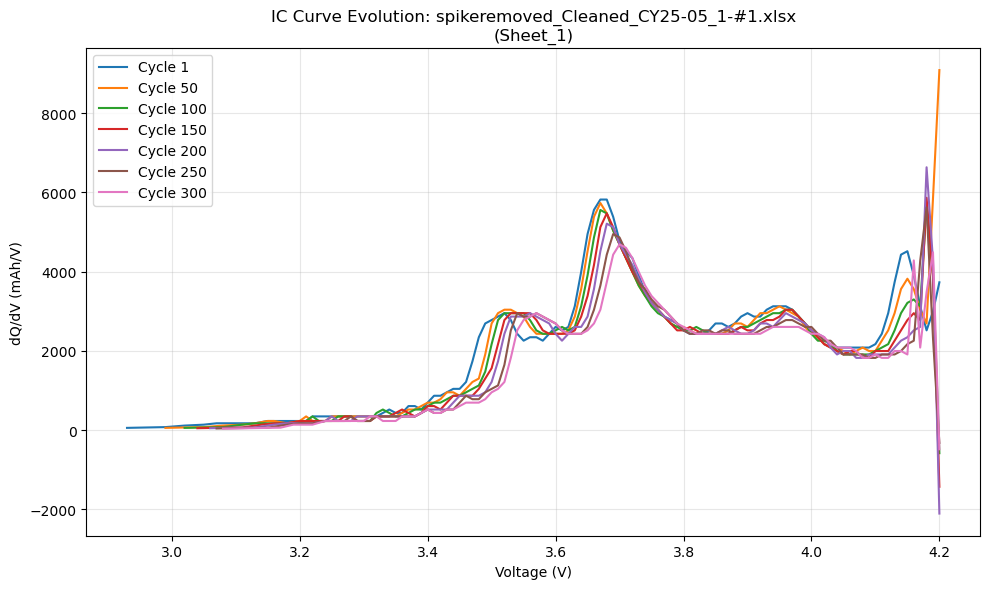

   >>> Plot generated. Stopping script as requested. <<<


In [7]:
# --- SETTINGS ---
VOLTAGE_STEP = 0.01   # Bin size in Volts (10mV)
CYCLE_INTERVAL = 50   # Process every Nth cycle

# --- COLUMN NAME MAPPING ---
COL_VOLTAGE = 'Ecell/V'
COL_CAPACITY = 'Q charge/mA.h'
COL_CYCLE = 'cycle number'

def calculate_ic_curve(cycle_df, cycle_num, voltage_step=0.01):
    """
    Calculates dQ/dV using voltage binning to smooth noise.
    """
    if COL_CAPACITY not in cycle_df.columns:
        return None, "Column missing"
        
    charge_data = cycle_df[cycle_df[COL_CAPACITY] > 0].copy()
    
    if charge_data.empty:
        return None, "No charge data > 0"

    # Sort and Bin
    charge_data = charge_data.sort_values(by=COL_VOLTAGE)
    charge_data['V_bin'] = (charge_data[COL_VOLTAGE] / voltage_step).round() * voltage_step

    # Average Capacity per bin
    binned = charge_data.groupby('V_bin')[COL_CAPACITY].mean()

    # Calculate Differential (dQ/dV)
    Q_clean = binned.values
    V_clean = binned.index.values

    # Gradient method for smoother derivative
    dQ = np.gradient(Q_clean)
    dV = np.gradient(V_clean)

    with np.errstate(divide='ignore', invalid='ignore'):
        dQdV = dQ / dV
    
    result_df = pd.DataFrame({
        'Voltage_V': V_clean,
        'dQ/dV': dQdV,
        'Cycle': cycle_num
    })
    
    result_df = result_df.replace([np.inf, -np.inf], np.nan).dropna()
    return result_df, "Success"

# --- MAIN EXECUTION ---

print("Autodetecting files...")
all_xlsx = glob.glob("**/*.xlsx", recursive=True)
target_files = [f for f in all_xlsx 
                if "spikeremoved_cleaned" in os.path.basename(f).lower() 
                and not os.path.basename(f).startswith("~$")]

if not target_files:
    print("❌ No files found!")
else:
    print(f"✅ Found {len(target_files)} target files. Looking for the first valid one to plot...")

# Flag to stop processing after first successful plot
plot_done = False

# --- LOOP THROUGH FILES ---
for file_idx, file_path in enumerate(target_files):
    if plot_done: break  # Stop outer loop if we plotted already
    
    file_name = os.path.basename(file_path)
    print(f"\nProcessing: {file_name}")
    
    try:
        xls = pd.ExcelFile(file_path)
        
        # Enumerate sheets
        for sheet_idx, sheet_name in enumerate(xls.sheet_names):
            if plot_done: break # Stop inner loop
            
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            df.columns = df.columns.str.strip()
            
            if COL_CAPACITY not in df.columns or COL_VOLTAGE not in df.columns:
                continue

            unique_cycles = sorted(df[COL_CYCLE].unique())
            cycles_to_process = [c for c in unique_cycles if c == 1 or c % CYCLE_INTERVAL == 0]
            
            # Storage for plotting multiple cycles on one graph
            curves_to_plot = []

            for cycle_num in cycles_to_process:
                cycle_data = df[df[COL_CYCLE] == cycle_num]
                
                # Calculate IC Curve
                ic_df, status = calculate_ic_curve(cycle_data, cycle_num, VOLTAGE_STEP)
                
                if ic_df is not None:
                    # Save for plotting
                    curves_to_plot.append((cycle_num, ic_df))

            # --- VISUALIZATION BLOCK ---
            # Plot gathered curves for this sheet if any exist
            if curves_to_plot:
                print(f"   >>> PLOTTING: {file_name} | {sheet_name} | Cycles: {[c for c, _ in curves_to_plot]} <<<")
                
                plt.figure(figsize=(10, 6))
                
                # Loop through the saved curves and plot them
                for cycle_num, data in curves_to_plot:
                    plt.plot(data['Voltage_V'], data['dQ/dV'], linewidth=1.5, label=f'Cycle {cycle_num}')
                
                plt.title(f"IC Curve Evolution: {file_name}\n({sheet_name})")
                plt.xlabel("Voltage (V)")
                plt.ylabel("dQ/dV (mAh/V)")
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show() 
                
                print("   >>> Plot generated. Stopping script as requested. <<<")
                plot_done = True # Trigger the break

    except Exception as e:
        print(f"  ❌ ERROR processing {file_name}: {e}")

if not plot_done:
    print("❌ Could not generate a plot. Check if files have valid charge data.")

In [10]:
import pandas as pd
import numpy as np
import glob
import os

# --- SETTINGS ---
VOLTAGE_STEP = 0.01  # Bin size in Volts (10mV). Controls smoothing & file size.
CYCLE_INTERVAL = 20   # <--- CHANGED FROM 50 TO 20 (Higher sampling rate)
OUTPUT_FILENAME = "All_IC_Curves_Summary.csv"

# --- COLUMN NAME MAPPING ---
COL_VOLTAGE = 'Ecell/V'
COL_CAPACITY = 'Q charge/mA.h'
COL_CYCLE = 'cycle number'

def calculate_ic_curve(cycle_df, cycle_num, voltage_step=0.01):
    """
    Calculates dQ/dV using voltage binning to smooth noise.
    Returns a DataFrame with Voltage and dQ/dV.
    """
    # 1. Check for column existence
    if COL_CAPACITY not in cycle_df.columns:
        return None, "Column missing"
        
    # 2. Filter for Charge phase (Capacity > 0)
    charge_data = cycle_df[cycle_df[COL_CAPACITY] > 0].copy()
    
    if charge_data.empty:
        return None, "No charge data > 0"

    # 3. Sort by Voltage (Crucial for dQ/dV)
    charge_data = charge_data.sort_values(by=COL_VOLTAGE)

    # 4. BINNING (Smoothing)
    # Round voltage to the nearest step (e.g., 3.01, 3.02...)
    charge_data['V_bin'] = (charge_data[COL_VOLTAGE] / voltage_step).round() * voltage_step

    # Take the average Capacity for each voltage bin
    binned = charge_data.groupby('V_bin')[COL_CAPACITY].mean()

    # 5. Calculate Differential (dQ/dV)
    Q_clean = binned.values
    V_clean = binned.index.values

    # Compute gradients
    dQ = np.gradient(Q_clean)
    dV = np.gradient(V_clean)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        dQdV = dQ / dV
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'Voltage_V': V_clean,
        'dQ/dV': dQdV,
        'Cycle': cycle_num
    })
    
    # Remove any infinite values caused by flat voltage steps
    result_df = result_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    return result_df, "Success"

# --- MAIN EXECUTION ---

print(f"Autodetecting files (Sampling every {CYCLE_INTERVAL}th cycle)...")

# 1. Find ALL xlsx files recursively
all_xlsx = glob.glob("**/*.xlsx", recursive=True)

# 2. Filter: Must contain "clean" (case-insensitive) to catch 'clean' OR 'cleaned'
# Make sure your files are named correctly (e.g. spikeremoved_Cleaned_...)
target_files = [f for f in all_xlsx 
                if "spikeremoved" in os.path.basename(f).lower() 
                and not os.path.basename(f).startswith("~$")]

if not target_files:
    print("❌ No files found with 'spikeremoved' in the name!")
    print("   Current Folder:", os.getcwd())
else:
    print(f"✅ Found {len(target_files)} target files: {[os.path.basename(f) for f in target_files]}")

all_results = []

for file_idx, file_path in enumerate(target_files):
    file_name = os.path.basename(file_path)
    print(f"\n[{file_idx+1}/{len(target_files)}] Processing: {file_name}")
    
    try:
        xls = pd.ExcelFile(file_path)
        
        for sheet_name in xls.sheet_names:
            # Read Sheet
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            
            # CLEANUP: Strip whitespace from column names
            df.columns = df.columns.str.strip()
            
            # Check for required columns
            required_cols = [COL_CYCLE, COL_VOLTAGE, COL_CAPACITY]
            missing = [c for c in required_cols if c not in df.columns]
            
            if missing:
                print(f"  ⚠️ Skipping '{sheet_name}': Missing columns {missing}")
                continue

            # Get list of unique cycles
            unique_cycles = sorted(df[COL_CYCLE].unique())
            
            # Filter: Get Cycle 1 + Every Nth cycle
            cycles_to_process = [c for c in unique_cycles if c == 1 or c % CYCLE_INTERVAL == 0]
            
            if not cycles_to_process:
                print(f"  ⚠️ Sheet '{sheet_name}': No matching cycles (1, {CYCLE_INTERVAL}...) found.")
                continue
            
            print(f"  > Sheet '{sheet_name}': Analyzing {len(cycles_to_process)} cycles...")
            
            count_for_sheet = 0
            for cycle_num in cycles_to_process:
                # Get data for this specific cycle
                cycle_data = df[df[COL_CYCLE] == cycle_num]
                
                # Calculate IC Curve
                ic_df, status = calculate_ic_curve(cycle_data, cycle_num, VOLTAGE_STEP)
                
                if ic_df is not None:
                    ic_df['Source_File'] = file_name
                    ic_df['Sheet_Name'] = sheet_name
                    all_results.append(ic_df)
                    count_for_sheet += 1
                else:
                    if cycle_num == 1:
                        print(f"    - Cycle 1 Skipped: {status}")

    except Exception as e:
        print(f"  ❌ ERROR processing {file_name}: {e}")

# --- EXPORT ---

if all_results:
    print("\nCompiling final dataset...")
    final_df = pd.concat(all_results, ignore_index=True)
    
    # Reorder columns
    cols = ['Source_File', 'Sheet_Name', 'Cycle', 'Voltage_V', 'dQ/dV']
    final_df = final_df[cols]
    
    print(f"Saving {len(final_df)} data points to {OUTPUT_FILENAME}...")
    final_df.to_csv(OUTPUT_FILENAME, index=False)
    print("✅ Done! File saved successfully.")
else:
    print("\n❌ No data was processed. Check the logs above.")

Autodetecting files (Sampling every 20th cycle)...
✅ Found 8 target files: ['spikeremoved_Cleaned_CY25-05_1-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_1-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_2-#3.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#1.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#2.xlsx', 'spikeremoved_Cleaned_CY25-05_4-#3.xlsx']

[1/8] Processing: spikeremoved_Cleaned_CY25-05_1-#1.xlsx
  > Sheet 'Sheet_1': Analyzing 18 cycles...
  > Sheet 'Sheet_2': Analyzing 15 cycles...
  > Sheet 'Sheet_3': Analyzing 15 cycles...

[2/8] Processing: spikeremoved_Cleaned_CY25-05_1-#2.xlsx
  > Sheet 'Sheet_1': Analyzing 18 cycles...
  > Sheet 'Sheet_2': Analyzing 15 cycles...
  > Sheet 'Sheet_3': Analyzing 16 cycles...
  > Sheet 'Sheet_4': Analyzing 1 cycles...

[3/8] Processing: spikeremoved_Cleaned_CY25-05_2-#1.xlsx
  > Sheet 'Sheet_1': Analyzing 20 cycles...
  > Sheet 'Sheet_2': Analyzing 17 cycles...
  > Sheet 'Sheet_3'